In [6]:
# Sel 1: Cek Ketersediaan GPU
import tensorflow as tf
import os

print("Versi TensorFlow:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print("GPU tersedia:", gpu_devices)
    print("Training akan menggunakan GPU.")
else:
    print("PERINGATAN: GPU TIDAK DITEMUKAN. Pastikan Anda sudah mengaktifkannya di Runtime > Change runtime type.")

# Perintah ini akan menampilkan detail GPU
!nvidia-smi

Versi TensorFlow: 2.19.0
GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training akan menggunakan GPU.
Sat Nov 15 20:09:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|  

In [7]:
# Sel 1: Mount Google Drive
!pip install -q gdown  # Install gdown (meskipun tidak dipakai download, ada di file asli)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Sel 2: Import Semua Library
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import zipfile

print(f"Versi TensorFlow: {tf.__version__}")

Versi TensorFlow: 2.19.0


In [9]:
# Sel 2.5: Salin data train ke disk lokal Colab
print("Menyalin data training dari Drive ke disk lokal Colab...")
print("Ini mungkin memakan waktu 5-10 menit, tapi akan mempercepat training secara drastis.")

!cp -r "/content/drive/MyDrive/ProyekBatik/hasil_augmentasi" "/content/hasil_augmentasi_local"

print("Data training selesai disalin ke '/content/hasil_augmentasi_local'")

Menyalin data training dari Drive ke disk lokal Colab...
Ini mungkin memakan waktu 5-10 menit, tapi akan mempercepat training secara drastis.
^C
Data training selesai disalin ke '/content/hasil_augmentasi_local'


In [10]:
# Sel 3 (DIREVISI): Definisi Path dan Parameter
import os

# --- Path untuk MENYIMPAN HASIL (di Google Drive) ---
BASE_DRIVE_PATH = "/content/drive/MyDrive/ProyekBatik"
os.makedirs(BASE_DRIVE_PATH, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, "model_transfer_learning_v1.keras")
BEST_MODEL_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, "model_transfer_learning_TERBAIK.keras")
HISTORY_PLOT_PATH = os.path.join(BASE_DRIVE_PATH, "plot_history_transfer_learning.png")
CM_PLOT_PATH = os.path.join(BASE_DRIVE_PATH, "confusion_matrix_transfer_learning.png")
REPORT_PATH = os.path.join(BASE_DRIVE_PATH, "classification_report_transfer_learning.txt")

# --- Path untuk MEMBACA DATA ---
# 1. Path Train (Sesuai permintaan Anda dari LOKAL COLAB)
train_dir = "/content/hasil_augmentasi_local" # <-- INI REVISINYA

# 2. Path Validasi & Test (Sesuai permintaan Anda dari file Zip yang diekstrak)
BASE_EXTRACT_PATH = "/content/dataset/dataset_batik_fix/processed_dataset"
validation_dir = os.path.join(BASE_EXTRACT_PATH, 'val')
test_dir = os.path.join(BASE_EXTRACT_PATH, 'test')

# --- Parameter Training ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 50

print(f"Semua hasil akan disimpan di: {BASE_DRIVE_PATH}")
print(f"Data Training dari: {train_dir} (Lokal)")
print(f"Data Validasi dari: {validation_dir} (Lokal)")
print(f"Data Test dari: {test_dir} (Lokal)")

Semua hasil akan disimpan di: /content/drive/MyDrive/ProyekBatik
Data Training dari: /content/hasil_augmentasi_local (Lokal)
Data Validasi dari: /content/dataset/dataset_batik_fix/processed_dataset/val (Lokal)
Data Test dari: /content/dataset/dataset_batik_fix/processed_dataset/test (Lokal)


In [11]:
#Tambahan
!pip install -q gdown  # Install gdown untuk download dari GDrive

# Mount Google Drive Anda (untuk MENYIMPAN hasil model nanti)
from google.colab import drive
drive.mount('/content/drive')

# File ID dari link Google Drive yang Anda berikan
file_id = "19GWEC95BAftlFKOsSztSCUk76ceTlVlt"
output_zip = "dataset_batik_fix.zip"
extract_path = "/content/dataset/"  # Path di dalam Colab

# Download file
!gdown --id {file_id} -O {output_zip}

# Buat folder tujuan dan ekstrak
import zipfile
os.makedirs(extract_path, exist_ok=True)

print(f"Mengekstrak '{output_zip}' ke '{extract_path}'...")
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Ekstraksi selesai.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19GWEC95BAftlFKOsSztSCUk76ceTlVlt
From (redirected): https://drive.google.com/uc?id=19GWEC95BAftlFKOsSztSCUk76ceTlVlt&confirm=t&uuid=11e3ac12-2826-476a-ab75-8116403a1eca
To: /content/dataset_batik_fix.zip
100% 2.09G/2.09G [00:17<00:00, 116MB/s]
Mengekstrak 'dataset_batik_fix.zip' ke '/content/dataset/'...
Ekstraksi selesai.


In [21]:
# Sel 4 (DIREVISI): Persiapan Data (Data Generators)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. Buat DUA datagen:
# Satu untuk data training (hanya preprocessing)
# Asumsi 'hasil_augmentasi' tidak perlu diaugmentasi lagi di sini
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Satu lagi untuk data validasi dan test (hanya preprocessing)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# 2. Buat train_generator (dari 'hasil_augmentasi')
print("Membuat generator data training...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# 3. Buat validation_generator (dari folder 'val')
print("Membuat generator data validasi...")
validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 4. Buat test_generator (dari folder 'test')
print("Membuat generator data test...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Dapatkan jumlah kelas secara dinamis (dari train_generator)
NUM_CLASSES = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())

print(f"\nGenerator berhasil dibuat.")
print(f"Ditemukan {NUM_CLASSES} kelas (pada data train): {class_names}")

# Cek apakah jumlah kelas di validasi sama
if validation_generator.num_classes != NUM_CLASSES:
    print(f"PERINGATAN: Jumlah kelas data validasi ({validation_generator.num_classes}) tidak sama dengan data train ({NUM_CLASSES})")

Membuat generator data training...
Found 41860 images belonging to 20 classes.
Membuat generator data validasi...
Found 600 images belonging to 20 classes.
Membuat generator data test...
Found 300 images belonging to 20 classes.

Generator berhasil dibuat.
Ditemukan 20 kelas (pada data train): ['batik_betawi', 'batik_bokor_kencono', 'batik_buketan', 'batik_dayak', 'batik_jlamprang', 'batik_kawung', 'batik_liong', 'batik_mega_mendung', 'batik_parang', 'batik_sekarjagad', 'batik_sidoluhur', 'batik_sidomukti', 'batik_sidomulyo', 'batik_singa_barong', 'batik_srikaton', 'batik_tribusono', 'batik_tujuh_rupa', 'batik_tuntrum', 'batik_wahyu_tumurun', 'batik_wirasat']


In [16]:
# Sel 4.5: Verifikasi dan Bersihkan Gambar di Folder Training

import os
from PIL import Image

# Path ke data training lokal Anda (dari Sel 3)
train_dir_local = "/content/hasil_augmentasi_local"

print(f"Memeriksa gambar di: {train_dir_local} ...")

removed_files = 0
for root, _, files in os.walk(train_dir_local):
    for f in files:
        filepath = os.path.join(root, f)
        try:
            # Coba buka gambar
            img = Image.open(filepath)
            img.verify() # Verifikasi bahwa ini file gambar yang valid
        except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
            print(f"ERROR: Menemukan file rusak/bukan gambar: {filepath}")
            # Hapus file yang rusak
            os.remove(filepath)
            print(f"-> Dihapus.")
            removed_files += 1

print(f"\nPemeriksaan selesai. Total file rusak dihapus: {removed_files}")
if removed_files > 0:
    print("Silakan jalankan ulang Sel 4 (Data Generators) untuk memperbarui generator.")
else:
    print("Dataset Anda bersih. Silakan lanjutkan ke Sel 5 (Bangun Model).")

Memeriksa gambar di: /content/hasil_augmentasi_local ...
ERROR: Menemukan file rusak/bukan gambar: /content/hasil_augmentasi_local/hasil_augmentasi/batik_kawung/-5-_jpg.rf.be1675d685bdbe2cb2f8540edbff0f2c_aug0_aug2.jpg
-> Dihapus.

Pemeriksaan selesai. Total file rusak dihapus: 1
Silakan jalankan ulang Sel 4 (Data Generators) untuk memperbarui generator.


In [19]:
# Sel 4.7: Periksa Perbedaan Kelas (Folder)

# Path dari Sel 3
train_path = "/content/hasil_augmentasi_local"
val_path = "/content/dataset/dataset_batik_fix/processed_dataset/val"

# Dapatkan daftar subfolder (kelas)
train_classes = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
val_classes = sorted([d for d in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, d))])

print(f"--- Ditemukan {len(train_classes)} kelas di folder TRAINING ({train_path}): ---")
print(train_classes)

print(f"\n--- Ditemukan {len(val_classes)} kelas di folder VALIDASI ({val_path}): ---")
print(val_classes)

# Temukan perbedaannya
extra_in_train = set(train_classes) - set(val_classes)
if extra_in_train:
    print(f"\nPERHATIAN: Folder ini ada di TRAIN tapi TIDAK ADA di VALIDASI:")
    print(f"-> {list(extra_in_train)}")
    print("Kemungkinan besar ini adalah folder yang menyebabkan error (cth: '.ipynb_checkpoints').")

--- Ditemukan 21 kelas di folder TRAINING (/content/hasil_augmentasi_local): ---
['batik_betawi', 'batik_bokor_kencono', 'batik_buketan', 'batik_dayak', 'batik_jlamprang', 'batik_kawung', 'batik_liong', 'batik_mega_mendung', 'batik_parang', 'batik_sekarjagad', 'batik_sidoluhur', 'batik_sidomukti', 'batik_sidomulyo', 'batik_singa_barong', 'batik_srikaton', 'batik_tribusono', 'batik_tujuh_rupa', 'batik_tuntrum', 'batik_wahyu_tumurun', 'batik_wirasat', 'hasil_augmentasi']

--- Ditemukan 20 kelas di folder VALIDASI (/content/dataset/dataset_batik_fix/processed_dataset/val): ---
['batik_betawi', 'batik_bokor_kencono', 'batik_buketan', 'batik_dayak', 'batik_jlamprang', 'batik_kawung', 'batik_liong', 'batik_mega_mendung', 'batik_parang', 'batik_sekarjagad', 'batik_sidoluhur', 'batik_sidomukti', 'batik_sidomulyo', 'batik_singa_barong', 'batik_srikaton', 'batik_tribusono', 'batik_tujuh_rupa', 'batik_tuntrum', 'batik_wahyu_tumurun', 'batik_wirasat']

PERHATIAN: Folder ini ada di TRAIN tapi TIDAK

In [20]:
!rm -rf "/content/hasil_augmentasi_local/hasil_augmentasi"
print("Folder 'hasil_augmentasi' yang berlebih telah dihapus dari direktori training.")

Folder 'hasil_augmentasi' yang berlebih telah dihapus dari direktori training.


In [22]:
# Sel 5: Membangun Model Transfer Learning

# 1. Lapisan Augmentasi Data (di dalam model)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=IMG_SHAPE),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name="data_augmentation")

# 2. Muat Model Dasar (Base Model)
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,  # Buang lapisan klasifikasi aslinya
    weights='imagenet'  # Gunakan bobot yang sudah dilatih di ImageNet
)

# 3. Bekukan Model Dasar
base_model.trainable = False

# 4. Bangun Model Lengkap
inputs = Input(shape=IMG_SHAPE, name="input_layer")
x = data_augmentation(inputs) # Augmentasi hanya aktif saat training
# (Preprocessing sudah dilakukan di generator)
x = base_model(x, training=False) # Jalankan base model dlm mode inference
x = GlobalAveragePooling2D(name="global_avg_pool")(x)
x = BatchNormalization(name="batch_norm_1")(x)
x = Dropout(0.5, name="dropout_1")(x) # REGULARISASI KUAT
x = Dense(128, activation='relu', name="dense_1")(x)
x = BatchNormalization(name="batch_norm_2")(x)
x = Dropout(0.3, name="dropout_2")(x) # Regularisasi kedua
outputs = Dense(NUM_CLASSES, activation='softmax', name="output_layer")(x)

model = Model(inputs, outputs)

print("Model berhasil dibangun.")

Model berhasil dibangun.


In [23]:
# Sel 6: Kompilasi Model & Callbacks

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model baru
model.summary()

# Siapkan Callbacks Profesional
# 1. Hentikan jika 'val_loss' tidak membaik setelah 5 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True, # Kembalikan bobot terbaik!
    verbose=1
)

# 2. Kurangi learning rate jika 'val_loss' mandek
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Kurangi LR sebesar 80% (1.0 -> 0.2)
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# 3. Simpan hanya model terbaik selama training
model_checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_SAVE_PATH, # Simpan di Google Drive
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, model_checkpoint]
print(f"\nModel dikompilasi. Checkpoint terbaik akan disimpan di: {BEST_MODEL_SAVE_PATH}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,164 (9.27 MB)

 Trainable params: 169,364 (661.58 KB)

 Non-trainable params: 2,260,800 (8.62 MB)


Model dikompilasi. Checkpoint terbaik akan disimpan di: /content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras


In [24]:
# Sel 7: Training (Tahap 1: Feature Extraction)

print("\n--- Memulai Training Tahap 1 (Feature Extraction) ---")

history = model.fit(
    train_generator,
    epochs=EPOCHS, # Ingat, EarlyStopping akan menghentikan jika sudah optimal
    validation_data=validation_generator,
    callbacks=callbacks
)

print("\n--- Training Tahap 1 Selesai ---")


--- Memulai Training Tahap 1 (Feature Extraction) ---
Epoch 1/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7506 - loss: 0.8814
Epoch 1: val_accuracy improved from -inf to 0.79500, saving model to /content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 96s 70ms/step - accuracy: 0.7507 - loss: 0.8811 - val_accuracy: 0.7950 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 2/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9137 - loss: 0.2681
Epoch 2: val_accuracy improved from 0.79500 to 0.81500, saving model to /content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - accuracy: 0.9137 - loss: 0.2681 - val_accuracy: 0.8150 - val_loss: 0.7014 - learning_rate: 0.0010
Epoch 3/50
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9317 - loss: 0.2103
Epoch 3: val_accuracy improved from 0.81500 to 0.82667, saving model to /content/drive/MyDrive/Proyek

In [25]:
# Sel 8: Mempersiapkan Fine-Tuning (Kompilasi Ulang)

print("\n--- Mempersiapkan Tahap 2 (Fine-Tuning) ---")

# Buka 'kunci' base_model
base_model.trainable = True

# Bekukan sebagian besar lapisan, latih hanya 30 lapisan terakhir
fine_tune_at = -30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang dengan LR yang SANGAT KECIL
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 100), # 100x lebih kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model dikompilasi ulang untuk Fine-Tuning.")
model.summary()


--- Mempersiapkan Tahap 2 (Fine-Tuning) ---
Model dikompilasi ulang untuk Fine-Tuning.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,164 (9.27 MB)

 Trainable params: 1,695,764 (6.47 MB)

 Non-trainable params: 734,400 (2.80 MB)

In [26]:
# Sel 9: Melanjutkan Training (Tahap 2: Fine-Tuning)

print("\n--- Memulai Training Tahap 2 (Fine-Tuning) ---")

# Tentukan epoch tambahan untuk fine-tuning
# Kita lanjutkan dari epoch terakhir tahap 1
initial_epochs = len(history.epoch)
fine_tune_epochs = 15 # Latih 15 epoch tambahan
total_epochs = initial_epochs + fine_tune_epochs

# Lanjutkan training
history_fine_tune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epochs, # Melanjutkan epoch
    validation_data=validation_generator,
    callbacks=callbacks # Gunakan callback yang sama
)

print("\n--- Training Tahap 2 (Fine-Tuning) Selesai ---")

# Gabungkan history training
history.epoch.extend(history_fine_tune.epoch)
for key in history.history:
    history.history[key].extend(history_fine_tune.history[key])


--- Memulai Training Tahap 2 (Fine-Tuning) ---
Epoch 11/25
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7913 - loss: 0.7132
Epoch 11: val_accuracy improved from 0.85000 to 0.87833, saving model to /content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 125s 87ms/step - accuracy: 0.7914 - loss: 0.7131 - val_accuracy: 0.8783 - val_loss: 0.4625 - learning_rate: 1.0000e-05
Epoch 12/25
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8993 - loss: 0.3170
Epoch 12: val_accuracy did not improve from 0.87833
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 112s 85ms/step - accuracy: 0.8993 - loss: 0.3170 - val_accuracy: 0.8650 - val_loss: 0.4857 - learning_rate: 1.0000e-05
Epoch 13/25
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9329 - loss: 0.2097
Epoch 13: val_accuracy improved from 0.87833 to 0.88667, saving model to /content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 112s 86

Membuat plot history training...


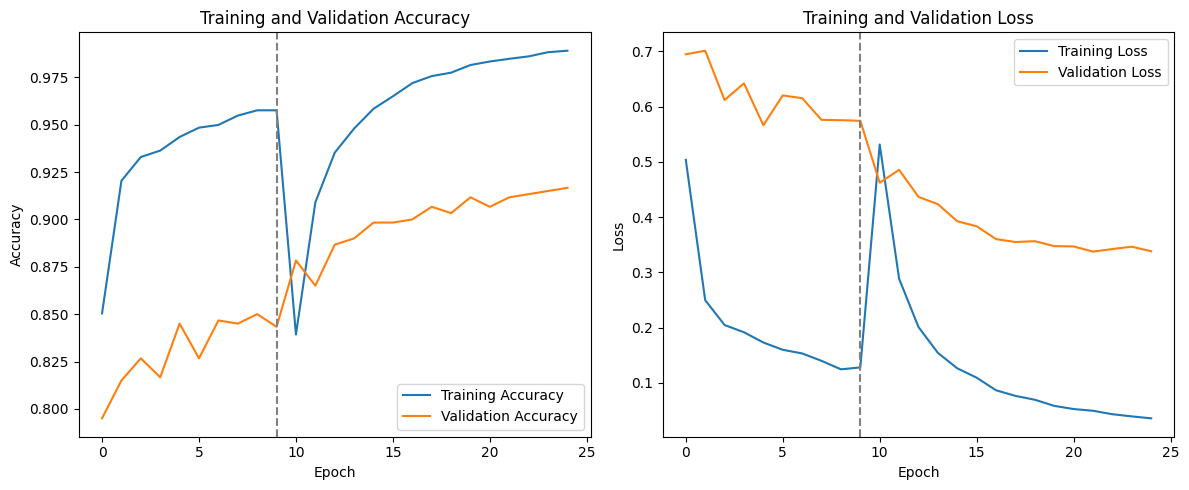

Plot history disimpan ke: /content/drive/MyDrive/ProyekBatik/plot_history_transfer_learning.png


In [27]:
# Sel 10: Visualisasi History Training

print("Membuat plot history training...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# Tandai titik di mana fine-tuning dimulai
plt.axvline(x=initial_epochs-1, color='grey', linestyle='--', label='Start Fine-Tuning')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.axvline(x=initial_epochs-1, color='grey', linestyle='--', label='Start Fine-Tuning')

plt.tight_layout()
plt.savefig(HISTORY_PLOT_PATH) # Simpan plot ke Drive
plt.show()

print(f"Plot history disimpan ke: {HISTORY_PLOT_PATH}")

In [28]:
# Sel 11: Evaluasi pada Test Set

print("Memuat model terbaik dari checkpoint...")
# Muat model terbaik yang disimpan oleh ModelCheckpoint
best_model = tf.keras.models.load_model(BEST_MODEL_SAVE_PATH)

print("Mengevaluasi model pada Test Set...")
results = best_model.evaluate(test_generator, verbose=1)

print("\n--- Hasil Evaluasi Test Set ---")
print(f"Test Loss:     {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({(results[1]*100):.2f}%)")

Memuat model terbaik dari checkpoint...
Mengevaluasi model pada Test Set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.9285 - loss: 0.3231

--- Hasil Evaluasi Test Set ---
Test Loss:     0.3162
Test Accuracy: 0.9267 (92.67%)



Membuat Laporan Klasifikasi dan Confusion Matrix...
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step

--- Classification Report ---
                     precision    recall  f1-score   support

       batik_betawi     1.0000    0.8667    0.9286        15
batik_bokor_kencono     1.0000    1.0000    1.0000        15
      batik_buketan     0.8824    1.0000    0.9375        15
        batik_dayak     0.9333    0.9333    0.9333        15
    batik_jlamprang     0.8000    0.8000    0.8000        15
       batik_kawung     0.6250    1.0000    0.7692        15
        batik_liong     1.0000    1.0000    1.0000        15
 batik_mega_mendung     0.8750    0.9333    0.9032        15
       batik_parang     0.9333    0.9333    0.9333        15
   batik_sekarjagad     1.0000    0.8667    0.9286        15
    batik_sidoluhur     1.0000    0.6667    0.8000        15
    batik_sidomukti     0.8750    0.9333    0.9032        15
    batik_sidomulyo     0.8667    0.8667    0.8667        15
 batik_singa_barong 

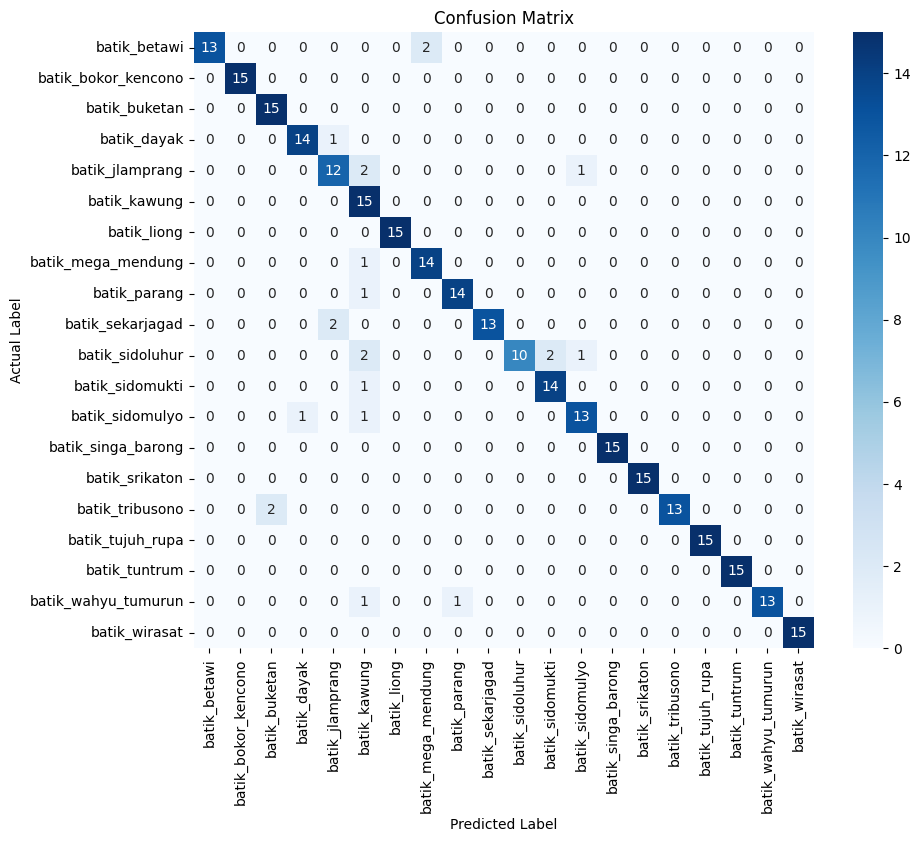

Plot Confusion Matrix disimpan ke: /content/drive/MyDrive/ProyekBatik/confusion_matrix_transfer_learning.png


In [29]:
# Sel 12: Laporan Klasifikasi dan Confusion Matrix

print("\nMembuat Laporan Klasifikasi dan Confusion Matrix...")

# Dapatkan prediksi
Y_pred_probabilities = best_model.predict(test_generator)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)

# Dapatkan label asli
Y_true = test_generator.classes

# 1. Classification Report
report = classification_report(Y_true, Y_pred, target_names=class_names, digits=4)
print("\n--- Classification Report ---")
print(report)

# Simpan laporan ke file di Drive
with open(REPORT_PATH, 'w') as f:
    f.write(f"Hasil Evaluasi Test Set (Model: {BEST_MODEL_SAVE_PATH})\n")
    f.write(f"Test Loss: {results[0]:.4f}\n")
    f.write(f"Test Accuracy: {results[1]:.4f} ({(results[1]*100):.2f}%)\n\n")
    f.write(report)
print(f"Laporan disimpan ke: {REPORT_PATH}")

# 2. Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(CM_PLOT_PATH) # Simpan confusion matrix ke Drive
plt.show()

print(f"Plot Confusion Matrix disimpan ke: {CM_PLOT_PATH}")

In [31]:
# Sel 13: Simpan Model Final

# Simpan juga model final (meskipun model terbaik sudah disimpan)
# Ini adalah model dari epoch terakhir, BUKAN model terbaik.
model.save(MODEL_SAVE_PATH)
print(f"\nModel final (epoch terakhir) berhasil disimpan di:")
print(f"{MODEL_SAVE_PATH}")
print("\nModel TERBAIK (rekomendasi) sudah disimpan di:")
print(f"{BEST_MODEL_SAVE_PATH}")

print("\n--- SEMUA PROSES SELESAI ---")


Model final (epoch terakhir) berhasil disimpan di:
/content/drive/MyDrive/ProyekBatik/model_transfer_learning_v1.keras

Model TERBAIK (rekomendasi) sudah disimpan di:
/content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras

--- SEMUA PROSES SELESAI ---
